In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.utils import shuffle
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
import PIL
from pathlib import Path
from tensorflow.keras.applications import VGG16, ResNet152, InceptionV3
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


In [2]:
train_path = "C:/Users/thoma/Desktop/speciale/DeepLearning_Master/Data\Windows_01/train"
batch_size = 18

def get_img_input_shape(for_model=False):
    if for_model:
        return(299,299,3)
    return (299, 299)


In [3]:
try:
    os.remove(train_path + "/.DS_Store")
except FileNotFoundError as e:
    print(f"file not found with error: {e}")

file not found with error: [WinError 2] Den angivne fil blev ikke fundet: 'C:/Users/thoma/Desktop/speciale/DeepLearning_Master/Data\\Windows_01/train/.DS_Store'


In [4]:
path = Path(train_path).rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(f"FOUND NON VALID IMAGE | path : {img_p} ")

In [5]:
for f in os.listdir(train_path):
    print(f)

Interictal
Preictal
Seizure


In [6]:
labels = [item for item in os.listdir(train_path)]
labels

['Interictal', 'Preictal', 'Seizure']

In [7]:
def inspect_class_distribution(path):
    dist_list = {}
    for i in os.listdir(path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        #dict = {classname, number_of_png}
        dist_list[classname] =  number_of_png
    return dist_list

inspect_class_distribution(train_path)

{'Interictal': '38919', 'Preictal': '9537', 'Seizure': '6963'}

In [8]:
max_n_images = int(inspect_class_distribution(train_path).get('Seizure'))

In [9]:
def limit_data(data_dir,n=max_n_images):
    a=[]
    for i in os.listdir(data_dir):
        image_path = random.sample(os.listdir(data_dir+'/'+i), max_n_images)
        for k,j in enumerate(image_path):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class'])

In [10]:
balanced_data = limit_data(train_path)

In [13]:
balanced_data.head()

,filename,class
5771,C:/Users/thoma/Desktop/speciale/DeepLearning_M...,Interictal
10508,C:/Users/thoma/Desktop/speciale/DeepLearning_M...,Preictal
1610,C:/Users/thoma/Desktop/speciale/DeepLearning_M...,Interictal
8973,C:/Users/thoma/Desktop/speciale/DeepLearning_M...,Preictal
18417,C:/Users/thoma/Desktop/speciale/DeepLearning_M...,Seizure


In [12]:
balanced_data = shuffle(balanced_data)

In [14]:
input = layers.Input(shape=get_img_input_shape(True), name="input")
covn01 = layers.Conv2D(32, (3, 3))(input)
acti01 = layers.Activation('relu')(covn01)
pool01 = layers.MaxPooling2D((2, 2))(acti01)
covn02 = layers.Conv2D(64, (3, 3))(pool01)
acti02 = layers.Activation('relu')(covn02)
pool02 = layers.MaxPooling2D(2, 2)(acti02)
covn03 = layers.Conv2D(128, (3, 3))(pool02)
acti02 = layers.Activation('relu')(covn02)
pool02 = layers.MaxPooling2D(2, 2)(acti02)
covn03 = layers.Conv2D(256, (3, 3))(pool02)
acti03 = layers.Activation('relu')(covn03)
pool03 = layers.MaxPooling2D((2, 2))(acti03)
flat = layers.Flatten()(pool03)

model_one = Model(inputs = input, outputs=flat)

model_two = Model(inputs = input, outputs=flat)

concat_feature_layer = layers.concatenate([model_one.output, model_two.output])
fully_connected_dense_big = layers.Dense(1024, activation='relu')(concat_feature_layer)
dropout_one = layers.Dropout(0.3)(fully_connected_dense_big)
flatten_layer = layers.Flatten()(dropout_one)
fully_connected_dense_small = layers.Dense(512, activation='relu')(flatten_layer)
dropout_two = layers.Dropout(0.3)(fully_connected_dense_small)
fully_connected_dense_class = layers.Dense(3, activation='softmax')(dropout_two)

model = Model(
    inputs=[model_one.input, model_two.input],
    outputs=fully_connected_dense_class
)

opt = Adam()

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()



ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [23]:
generator = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.3
)

test_generator = ImageDataGenerator(
  rescale=1./255, 
  validation_split=0.3
)

In [ ]:
train_generator_one = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

train_generator_two = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

input_1_train_gen = train_generator_one.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

input_2_train_gen = train_generator_two.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

input_1_validation_gen = train_generator_one.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")


input_2_validation_gen = train_generator_two.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")

def create_data_generator(data_gen_one, data_gen_two):

    while(True):
        _gen1, _gen1_l = next(data_gen_one)
        _gen2, _gen2_l = next(data_gen_two)

        yield [_gen1, _gen2], [_gen1_l, _gen2_l]

multi_train_generator = create_data_generator(
    input_1_train_gen,
    input_2_train_gen
    )

multi_validation_generator = create_data_generator(
    input_1_validation_gen,
    input_2_validation_gen
    )

In [25]:
x = 120
train_gen.classes[x:x+10]

[2, 1, 1, 1, 1, 1, 0, 0, 0, 2]

In [27]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=7, min_lr=0.000001)

In [32]:
history = model.fit(
    multi_train_generator,
    epochs=1,
    steps_per_epoch = multi_train_generator.samples//batch_size, 
    validation_data=multi_validation_generator, 
    validation_steps = multi_validation_generator.samples//batch_size,
    callbacks=[reduce_lr]    
)

Epoch 1/100
809/809 [==============================] - 286s 353ms/step - loss: 1.0259 - accuracy: 0.4639 - val_loss: 1.0568 - val_accuracy: 0.4732
Epoch 2/100
809/809 [==============================] - 299s 369ms/step - loss: 1.0183 - accuracy: 0.4676 - val_loss: 1.0576 - val_accuracy: 0.4443
Epoch 3/100
809/809 [==============================] - 300s 371ms/step - loss: 1.0171 - accuracy: 0.4731 - val_loss: 1.0157 - val_accuracy: 0.4703
Epoch 4/100
809/809 [==============================] - 299s 369ms/step - loss: 1.0170 - accuracy: 0.4655 - val_loss: 1.0192 - val_accuracy: 0.4758
Epoch 5/100
809/809 [==============================] - 300s 371ms/step - loss: 1.0181 - accuracy: 0.4691 - val_loss: 1.0561 - val_accuracy: 0.4536
Epoch 6/100
809/809 [==============================] - 300s 371ms/step - loss: 1.0132 - accuracy: 0.4777 - val_loss: 1.0318 - val_accuracy: 0.4727
Epoch 7/100
809/809 [==============================] - 300s 371ms/step - loss: 1.0073 - accuracy: 0.4733 - val_loss: 1

In [35]:
model.save("inceptionv3_100epoch_windows02.h5")

In [45]:
with open('history.txt', 'w') as f:
    f.write(str(history.history))

<Figure size 216x288 with 0 Axes>

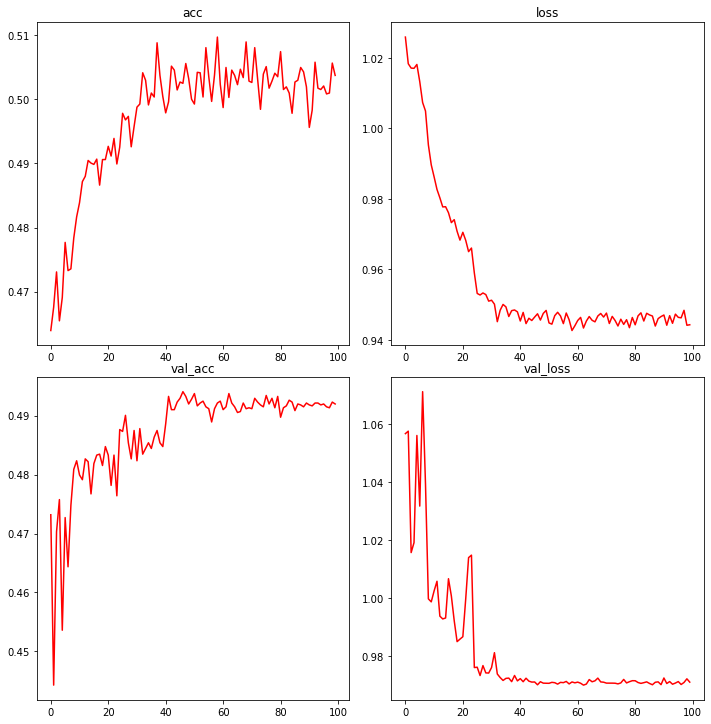

In [33]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
#plt.savefig("eval.png")

<Figure size 216x288 with 0 Axes>

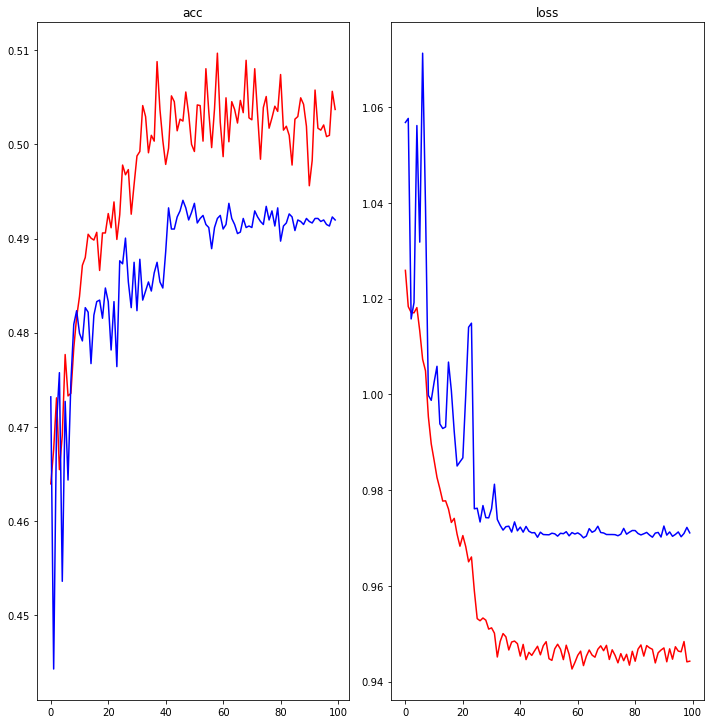

In [34]:
plt.figure(figsize=(3,4))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
plt.tight_layout()
ax1.set_title('acc')
ax1.plot(history.history['accuracy'], color='red')
ax1.plot(history.history['val_accuracy'], color='blue')

ax2.set_title('loss')
ax2.plot(history.history['loss'], color='red')
ax2.plot(history.history['val_loss'], color='blue')

In [36]:
test_gen = test_generator.flow_from_dataframe(
    balanced_data,
    batch_size=1, 
    target_size=img_input_shape, 
    shuffle=False,
    subset="validation"
    )

Found 6266 validated image filenames belonging to 3 classes.


In [37]:
number_of_step = test_gen.samples // 1
number_of_step

6266

In [38]:
pred = model.predict(test_gen, steps=number_of_step)

In [39]:
y_pred_max = pred.argmax(axis=-1)

In [40]:
y_true = test_gen.classes

In [41]:
for i, x in enumerate(test_gen.classes[0:6]):
    filename = test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

index : 0, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb10_30_391_T8-P8_05-24-27.png
index : 1, y_true : 2 : filename : E:/Windows_02/train/Seizure/chb10_38_78_T8-P8_15-51-21.png
index : 2, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb20_14_22_FP2-F4_06-00-47.png
index : 3, y_true : 2 : filename : E:/Windows_02/train/Seizure/chb01_16_50_F3-C3_03-02-36.png
index : 4, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb22_38_130_F3-C3_12-25-01.png
index : 5, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb18_35_241_T8-P8_09-38-24.png


In [42]:
labels = ['Interictal', 'Preictal', 'Seizure']

In [44]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [45]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.61      0.53      0.57      2091
    Preictal       0.59      0.66      0.62      2079
     Seizure       0.96      0.98      0.97      2096

    accuracy                           0.72      6266
   macro avg       0.72      0.72      0.72      6266
weighted avg       0.72      0.72      0.72      6266



In [51]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max), normalize='all')

confusion_matrix

array([[0.17602936, 0.14842004, 0.0092563 ],
       [0.11027769, 0.21800192, 0.00351101],
       [0.00303224, 0.00335142, 0.32812001]])

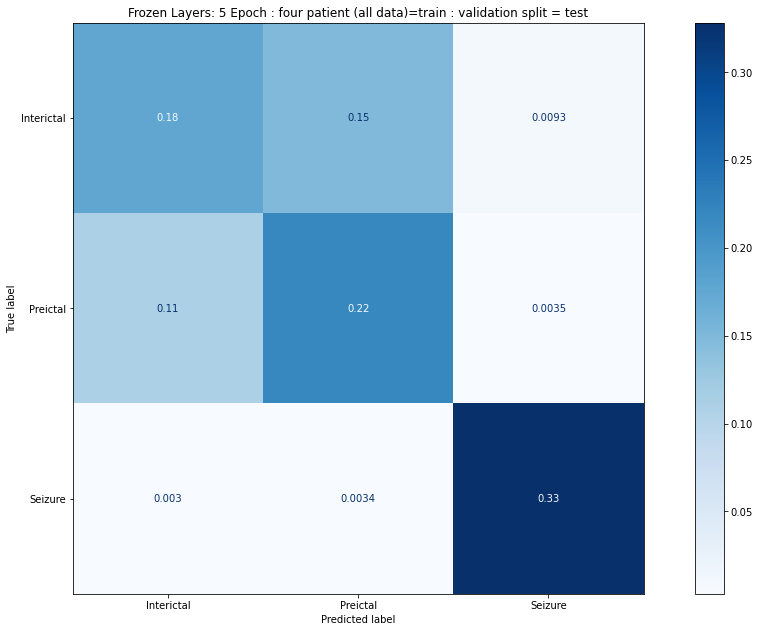

In [52]:
import matplotlib
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("resnet_only_sz_cb07_test.png")